In [1]:
import time
import numpy as np
import scipy as sp
import scipy.ndimage
import os
from IPython.display import display, clear_output, HTML
import sys

sys.path.append('../motion_clouds/')
from mcClass import *
import matplotlib.pyplot as plt
from matplotlib import animation
animation.rcParams['animation.writer']='ffmpeg'

%matplotlib inline



In [2]:
N = 128
fM = 2.0
fS = 1.0
octa = 1
th = 20
thS = 5
fT = 1.0/0.3
v = np.array([1.0,1.0])
MC = np.zeros((30), dtype=object)

i=0
for th in np.array([0,60,120,180,240,300]):
    v = 1.0*np.array([np.cos(th),np.sin(th)])
    for thS in np.array([2.5,5.0,10.0,20.0,40.0]):
        MC[i] = motionCloud(overSamp=2, N=N, chooseDev=0, show=0)
        MC[i].mcKernel(fM, fS, th, thS, fT, v, octa)
        MC[i].initGPU()
        i+=1


C:\Anaconda2\lib\site-packages\pyopencl\__init__.py:63: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


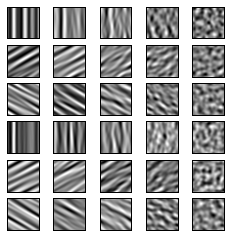

In [3]:
fig1, axes1 = plt.subplots(nrows=6, ncols=5,figsize=(4, 4))

i=0
for k in range(6):
    for l in range(5):    
        axes1[k,l].imshow(MC[i].getFrame(), cmap='gray')
        axes1[k,l].xaxis.set_visible(False)
        axes1[k,l].yaxis.set_visible(False)

        i+=1

In [6]:
# design the receptive field (RF) of neurons
isoOri = 0

x = np.linspace(-N/2,N/2-1,N)
X,Y = np.meshgrid(x,x)
sig = np.zeros(2)
sig[0] = N*0.05
sig[1] = N*0.1

a=fM*N/65.0 # spatial freq of RF
Neur = np.zeros((N,N,8))

if isoOri==1:
    thNeur = np.array([-np.pi/48,-np.pi/96,np.pi/96,np.pi/48,-np.pi/96,-np.pi/48,np.pi/48,np.pi/96])
else:
    thNeur = np.array([0.0,np.pi/4,np.pi/2,3*np.pi/4,0.0,np.pi/4,np.pi/2,3*np.pi/4])

x0 = np.array([np.cos(thNeur),np.sin(thNeur)]).T

k = 0
for i in range(8):
    Neur[:,:,i] = np.exp(-0.5*(X**2+Y**2)/sig[k]**2)*np.cos(x0[i,0]*X/a+x0[i,1]*Y/a)
    Neur[:,:,i] = Neur[:,:,i] - Neur[:,:,i].mean()
    if i==3:
        k=k+1

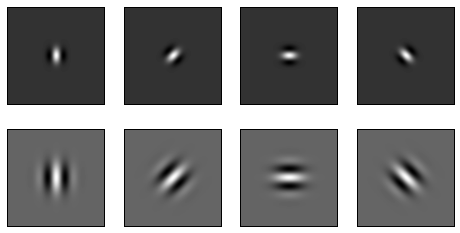

In [7]:
fig1, axes1 = plt.subplots(nrows=2, ncols=4,figsize=(8, 4))

i=0
for k in range(2):
    for l in range(4):
        axes1[k,l].imshow(Neur[:,:,i], cmap='gray');
        axes1[k,l].xaxis.set_visible(False)
        axes1[k,l].yaxis.set_visible(False)

        i+=1


In [8]:
#fig1.savefig('neurons.pdf', format='pdf', bbox_inches='tight') 

In [9]:
# simulate data

# residual firing rate (fr)
fr0 = 0.02 
dur = 200 #(*10 ms)
stimOn = 50
stimOff = 150
neurons = Neur.shape[2]
conds = MC.shape[0]
reps = 1

b = np.zeros((dur*10,neurons,conds,reps))

for l in range(neurons):
    for k in range(reps):
        for j in range(conds):
            for i in range(dur):
                if (i>=stimOn) & (i<stimOff):
                    fr = fr0+np.absolute((np.sum(MC[j].getFrame()*Neur[:,:,l])>0)\
                                            *np.sum(MC[j].getFrame()*Neur[:,:,l]))/200.0
                    b[10*i:10*(i+1),l,j,k]=np.random.poisson(fr,10)
                else: 
                    fr = fr0
                    b[10*i:10*(i+1),l,j,k]=np.random.poisson(fr,10)
            clear_output(wait=True)
            print 'Iteration: ', l, k, j
            sys.stdout.flush()
            
# remove multiple spikes that occur at the same time            
b[b>1]=1

Iteration:  7 0 29


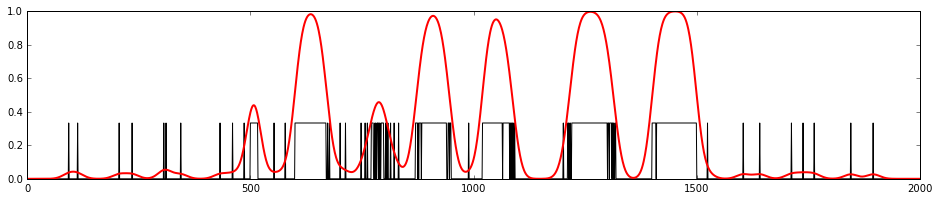

In [33]:
from scipy.ndimage.filters import *

fig0, axes0 = plt.subplots(nrows=1, ncols=1,figsize=(16,3));

interT = np.array(range(dur*10))
spik0 = b[:,0,5,0]
axes0.plot(interT, spik0/3, lw=1, color='k');
        
spik1 = gaussian_filter1d( spik0 , 15.0, axis=0 )
axes0.plot(interT, spik1/spik1.max() , lw=2, color='r');

In [32]:
#np.save('data/simul_SPK0', b)